In [ ]:
!pip install tf-nightly-gpu==2.4
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available()

ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu==2.4 (from versions: 2.4.0.dev20200902, 2.4.0.dev20200903, 2.4.0.dev20200904, 2.4.0.dev20200905, 2.4.0.dev20200906, 2.4.0.dev20200907, 2.4.0.dev20200908, 2.4.0.dev20200911, 2.4.0.dev20200912, 2.4.0.dev20200913, 2.4.0.dev20200914, 2.4.0.dev20200915, 2.4.0.dev20200916, 2.4.0.dev20200917, 2.4.0.dev20200918, 2.4.0.dev20200919, 2.4.0.dev20200920, 2.4.0.dev20200921, 2.4.0.dev20200922, 2.4.0.dev20200923, 2.4.0.dev20200924, 2.4.0.dev20200925, 2.4.0.dev20200926, 2.4.0.dev20200927, 2.4.0.dev20200928, 2.4.0.dev20200929, 2.4.0.dev20200930, 2.4.0.dev20201001, 2.4.0.dev20201002, 2.4.0.dev20201003, 2.4.0.dev20201004, 2.4.0.dev20201005, 2.4.0.dev20201007, 2.4.0.dev20201010, 2.4.0.dev20201011, 2.4.0.dev20201012, 2.4.0.dev20201014, 2.4.0.dev20201015, 2.4.0.dev20201016, 2.4.0.dev20201017, 2.4.0.dev20201018, 2.4.0.dev20201019, 2.4.0.dev20201020, 2.4.0.dev20201021, 2.4.0.dev20201022, 2.4.0.dev20201023, 2.5.0.dev20201024, 2.5.0.de

False

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [ ]:
!python3 --version

Python 3.6.9


In [ ]:
tf.__version__

'2.5.0-dev20201203'

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [ ]:
bitcoin_21month = pd.read_csv('/content/drive/MyDrive/BTCUSDT-21months.csv')

In [ ]:
bitcoin_21month['Timestamp'] = pd.to_datetime(bitcoin_21month['Timestamp'], unit='s')
bitcoin_21month = bitcoin_21month.set_index(['Timestamp'])
bitcoin_21month.interpolate(method='time', inplace=True)

bitcoin_21month['Close'] = bitcoin_21month['Close'].fillna(method='ffill')
bitcoin_21month['Weighted_Price'] = bitcoin_21month['Weighted_Price'].fillna(method='ffill')
bitcoin_21month['Volume_(BTC)'] = bitcoin_21month['Volume_(BTC)'].fillna(0)
bitcoin_21month['Volume_(USDT)'] = bitcoin_21month['Volume_(USDT)'].fillna(0)
bitcoin_21month['Open'] = bitcoin_21month['Open'].fillna(bitcoin_21month['Close'])
bitcoin_21month['High'] = bitcoin_21month['High'].fillna(bitcoin_21month['Close'])
bitcoin_21month['Low'] = bitcoin_21month['Low'].fillna(bitcoin_21month['Close'])

In [ ]:
test_df = bitcoin_21month.iloc[-86400:]
train_df = bitcoin_21month.iloc[-(86400 + 7 * 86400): -86400]

train_df_norm = (train_df - train_df.mean()) / train_df.std()
valid_df_norm = train_df_norm.iloc[-(len(train_df_norm))//5:]
train_df_norm = train_df_norm.iloc[-(len(train_df_norm))//5*4:]
test_df_estimate_norm = (test_df - train_df.iloc[-86400:].mean()) / train_df.iloc[-86400:].std()

In [ ]:
n_features = len(train_df_norm.columns)
window_size = 60
forecast_size = 60
batch_size = 64
buffer_size = 64
model_dim = 64
num_heads = 8
num_hidden_neurons = 512

In [ ]:
    def multivariate_data(dataset, target, start_index,
            end_index, history_size, target_size,
            step, single_step=True):
        data = []
        labels = []

        start_index = start_index + history_size
        if end_index is None:
            end_index = len(dataset - target_size)

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            if i + target_size < len(dataset):
                data.append(dataset[indices])

                if single_step:
                    labels.append(target[i+target_size])
                else:
                    labels.append(target[i:i+target_size])
            else:
                pass

        return np.array(data), np.array(labels)

In [ ]:
train_x, train_y = multivariate_data(train_df_norm.values, train_df_norm.values[:,6], 0, None, 60, 60, 1)
val_x, val_y = multivariate_data(valid_df_norm.values, valid_df_norm.values[:,6], 0, None, 60, 60, 1)
test_x, test_y = multivariate_data(test_df_estimate_norm.values, test_df_estimate_norm.values[:,6], 0, None, 60, 60, 1)

In [ ]:
train_x = train_x[:, :, 6]
val_x = val_x[:, :, 6]
test_x = test_x[:, :, 6]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_ds = val_ds.batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.batch(batch_size)

In [ ]:
# Model

def build_multi_head_attention_layers(model_dim, num_heads):
    multi_head_attention_layer = tf.keras.layers.MultiHeadAttention(
        model_dim, num_heads)   
    dropout = tf.keras.layers.Dropout(0.1)
    # normalization = LayerNormalization(epsilon=1e-6)
    normalization = tf.keras.layers.BatchNormalization()
    return multi_head_attention_layer, dropout, normalization

def build_feed_forward_layers(model_dim, num_hidden_neurons):
    feed_forward_layer = tf.keras.Sequential()
    feed_forward_layer.add(tf.keras.layers.Dense(num_hidden_neurons,
                                                 activation='relu'))
    feed_forward_layer.add(tf.keras.layers.Dense(model_dim))
        
    dropout = tf.keras.layers.Dropout(0.1)
    # normalization = LayerNormalization(epsilon=1e-6)
    normalization = tf.keras.layers.BatchNormalization()
    return feed_forward_layer, dropout, normalization

class PositionalEncoding(object):
    def __init__(self, position, d):
        angle_rads = self._get_angles(np.arange(position)[:, np.newaxis],
                                      np.arange(d)[np.newaxis, :], d)

        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])
        self._encoding = np.concatenate([sines, cosines], axis=-1)
        self._encoding = self._encoding[np.newaxis, ...]
    
    def _get_angles(self, position, i, d):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d))
        return position * angle_rates
    
    def get_positional_encoding(self):
        return tf.cast(self._encoding, dtype=tf.float32)

class PreProcessingLayer(tf.keras.layers.Layer):
    def __init__(self, model_dim, window_size):
        super(PreProcessingLayer, self).__init__()
        pe = PositionalEncoding(window_size, model_dim)
        self.pe = pe.get_positional_encoding()
        self.dropout = tf.keras.layers.Dropout(0.1)

    def call(self, sequence, training, mask):
        sequence_length = tf.shape(sequence)[1]
        sequence += self.pe[:, :sequence_length, :]
        sequence = self.dropout(sequence, training=training)
        return sequence
    
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_hidden_neurons, num_heads):
        super(EncoderLayer, self).__init__()

        # Build multi head attention layer and necessary additional layers
        self.multi_head_attention_layer, self.attention_dropout, self.attention_normalization = \
        build_multi_head_attention_layers(model_dim, num_heads)   
            
        # Build feed-forward neural network and necessary additional layers
        self.feed_forward_layer, self.feed_forward_dropout, self.feed_forward_normalization = \
        build_feed_forward_layers(model_dim, num_hidden_neurons)
       
    def call(self, sequence, training, mask):

        # Calculate attention output
        attnention_output, _ = self.multi_head_attention_layer(sequence, sequence, sequence, mask)
        attnention_output = self.attention_dropout(attnention_output, training=training)
        attnention_output = self.attention_normalization(sequence + attnention_output)
        
        # Calculate output of feed forward network
        output = self.feed_forward_layer(attnention_output)
        output = self.feed_forward_dropout(output, training=training)
        
        # Combine two outputs
        output = self.feed_forward_normalization(attnention_output + output)

        return output

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_hidden_neurons, num_heads):
        super(DecoderLayer, self).__init__()

        # Build multi head attention layers and necessary additional layers
        self.multi_head_attention_layer1, self.attention_dropout1, self.attention_normalization1 =\
        build_multi_head_attention_layers(model_dim, num_heads)   
        
        self.multi_head_attention_layer2, self.attention_dropout2, self.attention_normalization2 =\
        build_multi_head_attention_layers(model_dim, num_heads)           

        # Build feed-forward neural network and necessary additional layers
        self.feed_forward_layer, self.feed_forward_dropout, self.feed_forward_normalization = \
        build_feed_forward_layers(model_dim, num_hidden_neurons)

    def call(self, sequence, enconder_output, training, look_ahead_mask, padding_mask):

        attnention_output1, attnention_weights1 = self.multi_head_attention_layer1(sequence, sequence, sequence, look_ahead_mask)
        attnention_output1 = self.attention_dropout1(attnention_output1, training=training)
        attnention_output1 = self.attention_normalization1(sequence + attnention_output1)
        
        attnention_output2, attnention_weights2 = self.multi_head_attention_layer2(enconder_output, enconder_output, attnention_output1, padding_mask)
        attnention_output2 = self.attention_dropout1(attnention_output2, training=training)
        attnention_output2 = self.attention_normalization1(attnention_output1 + attnention_output2)

        output = self.feed_forward_layer(attnention_output2)
        output = self.feed_forward_dropout(output, training=training)
        output = self.feed_forward_normalization(attnention_output2 + output)

        return output, attnention_weights1, attnention_weights2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_hidden_neurons, num_heads, window_size, num_enc_layers = 6):
        super(Encoder, self).__init__()
        
        self.num_enc_layers = num_enc_layers
        
        self.pre_processing_layer = PreProcessingLayer(model_dim, window_size)
        self.encoder_layers = [EncoderLayer(model_dim, num_hidden_neurons, num_heads) for _ in range(num_enc_layers)]

    def call(self, sequence, training, mask):
        
        sequence = self.pre_processing_layer(sequence, training, mask)
        for i in range(self.num_enc_layers):
            sequence = self.encoder_layers[i](sequence, training, mask)

        return sequence

class Decoder(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_hidden_neurons, num_heads, window_size, num_dec_layers=6):
        super(Decoder, self).__init__()

        self.num_dec_layers = num_dec_layers
        
        self.pre_processing_layer = PreProcessingLayer(model_dim, window_size)
        self.decoder_layers = [DecoderLayer(model_dim, num_hidden_neurons, num_heads) for _ in range(num_dec_layers)]

    def call(self, sequence, enconder_output, training, look_ahead_mask, padding_mask):
            
        sequence = self.pre_processing_layer(sequence, training, mask)
        
        for i in range(self.num_dec_layers):

            sequence, attention_weights1, attention_weights2 = self.dec_layers[i](sequence, enconder_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_attention_weights1'.format(i+1)] = attention_weights1
            attention_weights['decoder_layer{}_attention_weights2'.format(i+1)] = attention_weights2

        return sequence, attention_weights

class Transformer(tf.keras.Model):
    def __init__(self, model_dim, num_heads, num_hidden_neurons, window_size):
        super(Transformer, self).__init__()

        self.encoder = Encoder(model_dim, num_hidden_neurons, num_heads, window_size)

        self.decoder = Decoder(model_dim, num_hidden_neurons, num_heads, window_size)

        self.final_layer = tf.keras.layers.Dense(1)

    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, model_dim)

        # dec_output.shape == (batch_size, tar_seq_len, model_dim)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [ ]:
transformer = Transformer(model_dim, 8, 64, 60)

In [ ]:
def build_multi_head_attention_layers(model_dim, num_heads):
    multi_head_attention_layer = tf.keras.layers.MultiHeadAttention(
        model_dim, num_heads)   
    dropout = tf.keras.layers.Dropout(0.1)
    # normalization = LayerNormalization(epsilon=1e-6)
    normalization = tf.keras.layers.BatchNormalization()
    return multi_head_attention_layer, dropout, normalization

def build_feed_forward_layers(model_dim, num_hidden_neurons):
    feed_forward_layer = tf.keras.Sequential()
    feed_forward_layer.add(tf.keras.layers.Dense(num_hidden_neurons,
                                                 activation='relu'))
    feed_forward_layer.add(tf.keras.layers.Dense(model_dim))
        
    dropout = tf.keras.layers.Dropout(0.1)
    # normalization = LayerNormalization(epsilon=1e-6)
    normalization = tf.keras.layers.BatchNormalization()
    return feed_forward_layer, dropout, normalization

class PreProcessingLayer(tf.keras.layers.Layer):
    def __init__(self, model_dim, window_size):
        super(PreProcessingLayer, self).__init__()
        pe = PositionalEncoding(window_size, model_dim)
        self.pe = pe.get_positional_encoding()
        self.dropout = tf.keras.layers.Dropout(0.1)

    def call(self, sequence, training):
        sequence_length = tf.shape(sequence)[1]
        sequence += self.pe[:, :sequence_length, :]
        sequence = self.dropout(sequence, training=training)
        return sequence

class PositionalEncoding(object):
    def __init__(self, position, d):
        angle_rads = self._get_angles(np.arange(position)[:, np.newaxis],
                                      np.arange(d)[np.newaxis, :], d)

        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])
        self._encoding = np.concatenate([sines, cosines], axis=-1)
        self._encoding = self._encoding[np.newaxis, ...]
    
    def _get_angles(self, position, i, d):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d))
        return position * angle_rates
    
    def get_positional_encoding(self):
        return tf.cast(self._encoding, dtype=tf.float32)

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_hidden_neurons, num_heads):
        super(EncoderLayer, self).__init__()

        # Build multi head attention layer and necessary additional layers
        self.multi_head_attention_layer, self.attention_dropout, self.attention_normalization = \
        build_multi_head_attention_layers(model_dim, num_heads)   
            
        # Build feed-forward neural network and necessary additional layers
        self.feed_forward_layer, self.feed_forward_dropout, self.feed_forward_normalization = \
        build_feed_forward_layers(model_dim, num_hidden_neurons)
       
    def call(self, sequence, training):

        # Calculate attention output
        attnention_output, _ = self.multi_head_attention_layer(sequence, sequence, sequence)
        attnention_output = self.attention_dropout(attnention_output, training=training)
        attnention_output = self.attention_normalization(sequence + attnention_output)
        
        # Calculate output of feed forward network
        output = self.feed_forward_layer(attnention_output)
        output = self.feed_forward_dropout(output, training=training)
        
        # Combine two outputs
        output = self.feed_forward_normalization(attnention_output + output)

        return output

class Encoder(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_hidden_neurons, num_heads, window_size, num_enc_layers = 6):
        super(Encoder, self).__init__()
        
        self.num_enc_layers = num_enc_layers
        
        # self.pre_processing_layer = PreProcessingLayer(model_dim, window_size)
        self.encoder_layers = [EncoderLayer(model_dim, num_hidden_neurons, num_heads) for _ in range(num_enc_layers)]

    def call(self, sequence, training):
        
        # sequence = self.pre_processing_layer(sequence, training)
        for i in range(self.num_enc_layers):
            sequence = self.encoder_layers[i](sequence, training)

        return sequence

class TST(tf.keras.Model):
    def __init__(self, model_dim, num_heads, num_hidden_neurons, window_size):
        super(TST, self).__init__()
        self.encoder = Encoder(model_dim, num_hidden_neurons, num_heads, window_size)
        self.final_layer = tf.keras.layers.Dense(1)

    def call(self, inp, tar, training):

        enc_output = self.encoder(inp, training)  # (batch_size, inp_seq_len, model_dim)

        # dec_output.shape == (batch_size, tar_seq_len, model_dim)
        # dec_output, attention_weights = self.decoder(
        #     tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        # final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        final_output = tf.keras.layers.Dense(1)(enc_output)
        return final_output
        # return final_output, attention_weights

In [ ]:
tst = TST(model_dim, 8, batch_size, 60)

In [ ]:
train_x.shape

(483720, 60, 7)

In [ ]:
pred = tst(train_x, train_y, True)

AttributeError: ignored

In [ ]:
# inputs1 = tf.keras.layers.Input(shape=(60, 7))
inputs = tf.keras.layers.Input(shape=(60, 1))
# att_layer = tf.keras.layers.MultiHeadAttention(model_dim, num_heads)(inputs, inputs)
att_layer = tf.keras.layers.MultiHeadAttention(model_dim, num_heads)(inputs, inputs)
dropout = tf.keras.layers.Dropout(0.1)(att_layer)
norm = tf.keras.layers.BatchNormalization()(dropout)
d1 = tf.keras.layers.Dense(num_hidden_neurons, activation='relu')(norm)
d2 = tf.keras.layers.Dense(model_dim)(d1)
norm2 = tf.keras.layers.BatchNormalization()(d2)
outputs = tf.keras.layers.Dense(1)(norm2)
tst_model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
tst_model.compile(optimizer='adam', loss='mse')

In [ ]:
train_x.shape

(483720, 60)

In [ ]:
tst_model.fit(train_x, train_y, batch_size=64, epochs=20)

In [ ]:
tst_model.save('tst_model.h5')

In [ ]:
tst_model.save('/content/drive/MyDrive/tst_model.h5')

In [ ]:
tst_model = tf.keras.models.load_model('/content/drive/MyDrive/tst_model.h5')

In [ ]:
train_x.shape

(483720, 60)

In [ ]:
tst_model.evaluate(test_x, test_y, batch_size=batch_size)

1349/1349 [==============================] - 156s 115ms/step - loss: 0.0569


0.05686003342270851

In [ ]:
preds = tst_model.predict(test_x)

In [ ]:
preds.shape

(86280, 60, 1)

In [ ]:
preds[0][-1].shape

(1,)

In [ ]:
test_x.shape

(86280, 60)

In [ ]:
preds_wp = preds[:,59,:]

In [ ]:
preds_wp.shape

(86280, 1)

In [ ]:
target_wp = test_y

In [ ]:
target_wp.shape

(86280,)

In [ ]:
import matplotlib.pyplot as plt

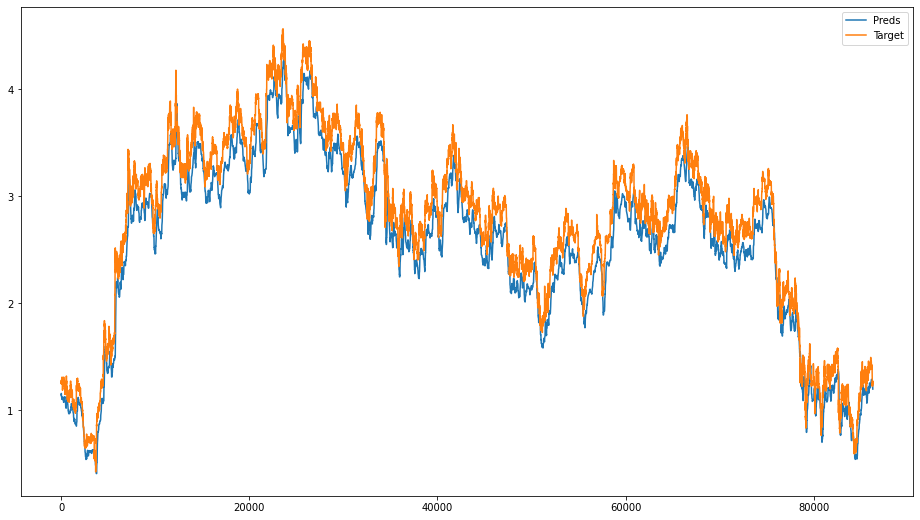

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(preds_wp, label='Preds')
plt.plot(target_wp, label='Target')
plt.legend(loc=0)

In [ ]:
to_save_data = {'preds':preds_wp.ravel(), 'targets':target_wp}
to_save = pd.DataFrame(data=to_save_data)
to_save.to_csv('/content/drive/MyDrive/transformer_preds.csv')

In [ ]:
mae = np.sum(np.absolute(preds_wp.ravel() - target_wp.ravel())) / len(preds_wp)

In [ ]:
mae

0.21492822136605985

In [ ]:
len(target_wp)

86280

In [ ]:
np.array(preds_wp) - np.array(target_wp)